In [22]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from commons.configuration_manager import ConfigurationManager
from src.learning.training.training_transformer import TrainingTransformer
from src.learning.training.label_collector import LabelCollector
from src.learning.training.training_file_reader import TrainingFileReader
from src.learning.models import create_cnn, create_mlp, create_multi_model

config_manager = ConfigurationManager()
config = config_manager.config

reader = TrainingFileReader(path_to_training='../../training/laps/')
transformer = TrainingTransformer(config)
collector = LabelCollector()

def memory_creator(new_frame, memory, length=4, interval=2):
    memory.append(new_frame)
    
    near_memory = memory[::-interval]
    if len(near_memory) < length:
        return None
    
    if len(memory) >= length * interval:
        memory.pop(0)
        
    return np.concatenate(near_memory, axis=2)

def plot_stuff(title, plot_elems, figsize=(18, 10)):
    fig=plt.figure(figsize=figsize)
    plt.title(title)
    #plt.ylabel('dunno')
    plt.xlabel('Epoch')
    
    for plot_elem in plot_elems:
        plt.plot(plot_elem['data'], label=plot_elem['label'], alpha=plot_elem['alpha'])

    plt.grid(axis='x')
    plt.legend(loc='best', prop={'size': 15})
    plt.show()

filenames = ['lap_5_2020_01_24', 'lap_6_2020_01_24', 'lap_7_2020_01_24']

In [2]:
def read_stored_data(filename):
    df = reader.read_telemetry_as_csv(filename + '.csv')
    telemetry = collector.collect_numeric_inputs(df)
    diffs = collector.collect_expert_labels(df)

    frames = reader.read_training_video(filename + '.avi')
    resized_frames_np = transformer.resize_video_for_training(frames)

    #telemetry_np = telemetry.to_numpy()
    #diffs_np = diffs.to_numpy()
    
    return resized_frames_np, telemetry, diffs

#frames_train, frames_test, telemetry_train, telemetry_test, diffs_train, diffs_test = train_test_split(resized_frames_np, telemetry_np, diffs_np, test_size=0.2)

In [3]:
def prep_mem_datas(frames, telemetry, diffs, length, interval):
    mem_telemetry = telemetry
    mem_diffs = diffs
    
    memory = []
    mem_frames = []
    for frame in frames:
        mem_frame = memory_creator(frame, memory, length=length, interval=interval)

        if mem_frame is not None:
            mem_frames.append(mem_frame)

    mem_frames_np = np.array(mem_frames)

    len_diff = mem_telemetry.shape[0] - mem_frames_np.shape[0]
    if len_diff > 0:
        mem_telemetry = mem_telemetry.iloc[len_diff:]
        mem_diffs = mem_diffs.iloc[len_diff:]
    
    mem_telemetry_np = mem_telemetry.to_numpy()
    mem_diffs_np = mem_diffs.to_numpy()

    return mem_frames_np, mem_telemetry_np, mem_diffs_np

In [4]:
experiments = [(1, 1), (4, 1), (4, 4), (4, 8), (4, 12), (6, 4), (6, 8), (6, 12)]
datas_list = []

for experiment in tqdm(experiments):
    frames_mem = None
    telemetry_mem = None
    diffs_mem = None
    
    for training_file in filenames:
        frames_i, telem_i, diffs_i = prep_mem_datas(*read_stored_data(training_file), *experiment)
        
        if frames_mem is None and telemetry_mem is None and diffs_mem is None:
            frames_mem = frames_i
            telemetry_mem = telem_i
            diffs_mem = diffs_i
        else:
            frames_mem = np.append(frames_mem, frames_i, axis=0)
            telemetry_mem = np.append(telemetry_mem, telem_i, axis=0)
            diffs_mem = np.append(diffs_mem, diffs_i, axis=0)
        
    datas_list.append((frames_mem, telemetry_mem, diffs_mem))

In [6]:
epochs = 6
batch_size = 32
verbose = 0

results = {}

for data in tqdm(datas_list):
    result_desc = "N={}, M={}".format(*experiments[datas_list.index(data)])
    tqdm.write(result_desc)
    
    frames_train, frames_test, telemetry_train, telemetry_test, diffs_train, diffs_test = train_test_split(*data, test_size=0.2)
    
    losses = []
    val_losses = []
    for i in tqdm(range(0, 10)):
        mlp = create_mlp()
        cnn = create_cnn(input_shape=frames_train[0].shape)
        multi = create_multi_model(mlp, cnn)
    
        hist = multi.fit([telemetry_train, frames_train], diffs_train,
                        validation_data=([telemetry_test, frames_test], diffs_test),
                        epochs=epochs, batch_size=batch_size, verbose=verbose)
        
        losses.append(hist.history['loss'])
        val_losses.append(hist.history['val_loss'])
    
    mean_losses = [np.mean(i) for i in zip(*losses)]
    mean_val_losses = [np.mean(i) for i in zip(*val_losses)]
    
    results[result_desc] = mean_losses
    results[result_desc + "_val"] = mean_val_losses
    
    tqdm.write("Mean loss per epoch: {}".format(mean_losses))
    tqdm.write("Mean validation loss per epoch: {}".format(mean_val_losses))

print(results)

N=1, M=1



Mean loss per epoch: [0.28192023635907143, 0.1259698601820804, 0.08427493948300296, 0.06644767107299772, 0.05642307181627643, 0.04956664783449079]
Mean validation loss per epoch: [0.12865957306065298, 0.07259656297423853, 0.051586490188855735, 0.04233955453823087, 0.036740886711595575, 0.032741382805888244]
N=4, M=1


/home/martin/miniconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  



Mean loss per epoch: [0.36260394937772833, 0.1398121181892889, 0.09204443301192071, 0.07245687838415699, 0.06060085965427544, 0.05222109768371347]
Mean validation loss per epoch: [0.1443030319256748, 0.08091493532297422, 0.06109101926894496, 0.05013935999582997, 0.04260531310619211, 0.036972212183604136]
N=4, M=4


/home/martin/miniconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  



Mean loss per epoch: [0.30775782553750347, 0.13577826158245254, 0.08827334094757437, 0.06745978360564117, 0.05717717161681431, 0.049578445631058496]
Mean validation loss per epoch: [0.14732765705896383, 0.08540894730741251, 0.05858269458395088, 0.04861275869676633, 0.04334642141735348, 0.03896956964387888]
N=4, M=8


/home/martin/miniconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  



Mean loss per epoch: [0.3389941971919083, 0.1382035187154509, 0.08760754412189686, 0.06709084875649245, 0.0567602254656923, 0.04984530511186827]
Mean validation loss per epoch: [0.13885941472944757, 0.07929243517406512, 0.055325300908541784, 0.045579736776716645, 0.040183535285580205, 0.03630989196412039]
N=4, M=12


/home/martin/miniconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  



Mean loss per epoch: [0.2936326068135143, 0.1380588471410761, 0.09326249772933475, 0.07138445832827242, 0.05858208930553861, 0.049464237092847245]
Mean validation loss per epoch: [0.14842677132502824, 0.08945247080969569, 0.06089555716646131, 0.04841353760441892, 0.03920689918413521, 0.03248959111645494]
N=6, M=4


/home/martin/miniconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  



Mean loss per epoch: [0.3153836815103056, 0.13255534161574173, 0.08950733500135627, 0.07031520419131908, 0.05943141157778784, 0.05178654259027743]
Mean validation loss per epoch: [0.1302596666230612, 0.0740924675937898, 0.05656379348986808, 0.04591894499995191, 0.03934443484997164, 0.03501549622726668]
N=6, M=8


/home/martin/miniconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  



Mean loss per epoch: [0.3917887741991958, 0.14386448506371083, 0.09169717927532814, 0.07076599997831785, 0.0592989006492051, 0.05218623752606618]
Mean validation loss per epoch: [0.14184114139946757, 0.08092302264655946, 0.058554675451205004, 0.04912520867146394, 0.04333343456361455, 0.03898325925080665]
N=6, M=12


/home/martin/miniconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  



Mean loss per epoch: [0.3202774922670562, 0.13435733226190047, 0.09068684297202481, 0.07149361488516942, 0.06006527264775592, 0.052279077919275586]
Mean validation loss per epoch: [0.1322958852607509, 0.0772995583113284, 0.05606482762862858, 0.04541822320726706, 0.038926013540481974, 0.03397772958980149]

{'N=1, M=1': [0.28192023635907143, 0.1259698601820804, 0.08427493948300296, 0.06644767107299772, 0.05642307181627643, 0.04956664783449079], 'N=1, M=1_val': [0.12865957306065298, 0.07259656297423853, 0.051586490188855735, 0.04233955453823087, 0.036740886711595575, 0.032741382805888244], 'N=4, M=1': [0.36260394937772833, 0.1398121181892889, 0.09204443301192071, 0.07245687838415699, 0.06060085965427544, 0.05222109768371347], 'N=4, M=1_val': [0.1443030319256748, 0.08091493532297422, 0.06109101926894496, 0.05013935999582997, 0.04260531310619211, 0.036972212183604136], 'N=4, M=4': [0.30775782553750347, 0.13577826158245254, 0.08827334094757437, 0.06745978360564117, 0.05717717161681431, 0.04

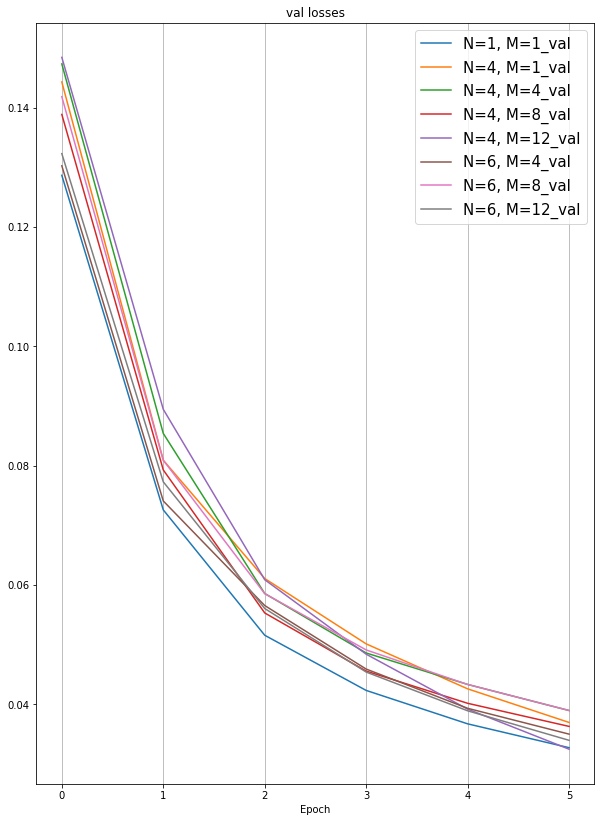

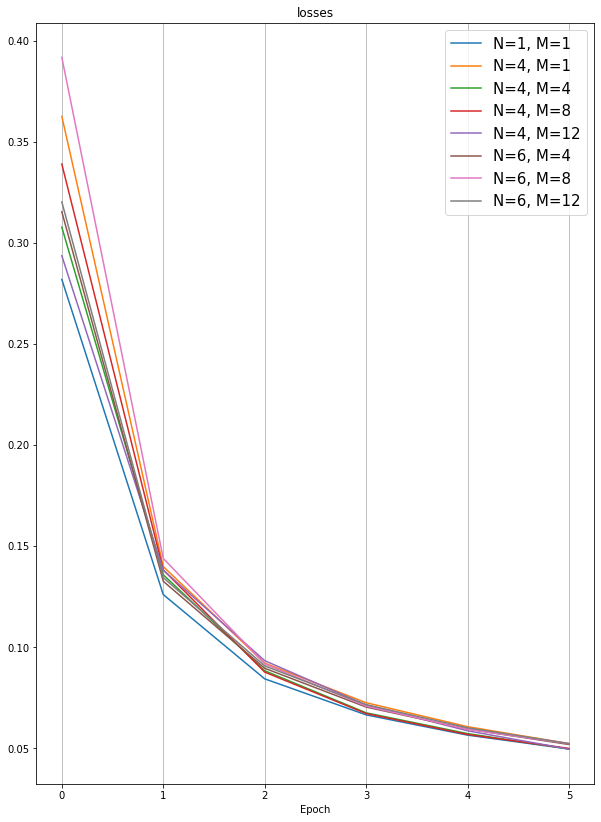

In [24]:
loss_data = []
val_loss_data = []

for key, loss in results.items():
    if "_val" in key:
        val_loss_data.append({'data': loss, 'label': key, 'alpha': 1.0})
    else:
        loss_data.append({'data': loss, 'label': key, 'alpha': 1.0})

plot_stuff("val losses", val_loss_data, figsize=(10, 14))
plot_stuff("losses", loss_data, figsize=(10, 14))

In [ ]:
mlp = create_mlp()
cnn = create_cnn(input_shape=frames_train[0].shape)
multi = create_multi_model(mlp, cnn)
#multi.summary()

multi.fit([telemetry_train, frames_train], diffs_train,
                validation_data=([telemetry_test, frames_test], diffs_test),
                epochs=epochs,
                batch_size=batch_size,
                verbose=verbose)